In [1]:
import os
import joblib

import pandas as pd
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from model_settings import ms
from plotters import PlotCols
import matplotlib.pyplot as plt

ms.find_root(Path())

# functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def CompareDists(X,Y):
    bins=int(np.sqrt(min(len(X),len(Y))))
    try:
        xlabel = X.name.replace('_',' ')
    except Exception:
        xlabel = ''
    try:
        ylabel = Y.name.replace('_',' ')
    except Exception:
        ylabel = ''
    plt.figure()
    plt.hist(X,bins=bins,label=xlabel,density=True,color='green')
    plt.hist(Y,bins=bins,label=ylabel,density=True,color='purple',histtype='step')
    plt.legend()
    plt.show()

# loading model

In [3]:
root = os.path.join(ms.root)
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if not f.startswith('.') and f.find('Legacy')])
for i,m in enumerate(models):
    print(f"{i}     {m}")
i = int(input('select model: '))
selected_model = models.iloc[i]

0     2024-12-03 115353819604 inital cboe spx relative asian
1     2024-12-03 221708375538 inital cboe spx relative barrier
2     2024-12-06 024553040968 inital cboe spx relative barrier


select model:  2


In [4]:
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
pricename = f"{selected_model[selected_model.rfind(' ')+1:]}_price"
initial = model['model']
model

{'seed': 710,
 'raw_data':          spot_price  strike_price  barrier  days_to_maturity     w  \
 0            1274.0         637.0    637.0                60  call   
 1            1274.0         637.0    637.0                60   put   
 2            1274.0         637.0    637.0                60  call   
 3            1274.0         637.0    637.0                60   put   
 4            1274.0         637.0    637.0                90  call   
 ...             ...           ...      ...               ...   ...   
 4067275      5857.0        8785.5   8785.5               540   put   
 4067276      5857.0        8785.5   8785.5               720  call   
 4067277      5857.0        8785.5   8785.5               720   put   
 4067278      5857.0        8785.5   8785.5               720  call   
 4067279      5857.0        8785.5   8785.5               720   put   
 
         barrier_type_name  rebate  dividend_rate  risk_free_rate  \
 0                 DownOut     0.0       0.020858  

In [5]:
pricename

'barrier_price'

In [6]:
model['model']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['days_to_maturity',
                                                   'dividend_rate',
                                                   'risk_free_rate', 'theta',
                                                   'kappa', 'rho', 'eta', 'v0',
                                                   'relative_spot',
                                                   'relative_barrier',
                                                   'relative_rebate']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['w',
                                                   'barrier_type_name'])])),
                ('regressor',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(20,),
                              learning_rate='adaptive', learning_rate_init=0.1,
                              max_iter=500, n_iter_no_change=20,
                              random_state=710, solver='sgd'))])

In [7]:
test_data = model['test_data']
test_data['sqerr'] = test_data['outofsample_error']**2

In [8]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
model
fitted
runtime
numerical_scaler
mlp_params
transformers
mlp_start
mlp_end


In [9]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

dividend rate: 
0       0.012624
1       0.012628
2       0.012641
3       0.012671
4       0.012687
          ...   
1152    0.023672
1153    0.023681
1154    0.023780
1155    0.023823
1156    0.024133
Name: dividend_rate, Length: 1157, dtype: float64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
781    0.054494
782    0.054500
783    0.054513
784    0.054801
785    0.054889
Name: risk_free_rate, Length: 786, dtype: float64

theta: 
0       8.181674e-11
1       4.564269e-10
2       4.968155e-10
3       6.916618e-10
4       1.119760e-09
            ...     
1747    1.700398e+00
1748    1.732709e+00
1749    1.811241e+00
1750    1.836051e+00
1751    1.869788e+00
Name: theta, Length: 1752, dtype: float64

kappa: 
0       3.553361e-10
1       3.924365e-10
2       7.518568e-10
3       8.464905e-10
4       1.055398e

In [10]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
print(model['feature_set'])
model['numerical_features']

['days_to_maturity', 'dividend_rate', 'risk_free_rate', 'theta', 'kappa', 'rho', 'eta', 'v0', 'relative_spot', 'relative_barrier', 'relative_rebate', 'w', 'barrier_type_name']


['days_to_maturity',
 'dividend_rate',
 'risk_free_rate',
 'theta',
 'kappa',
 'rho',
 'eta',
 'v0',
 'relative_spot',
 'relative_barrier',
 'relative_rebate']

In [11]:
full_dataset = pd.concat([train_data,test_data])
test_dates = test_data['date'].drop_duplicates().reset_index(drop=True)
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates = pd.to_datetime(all_dates,format='mixed')

retraining_frequency = 20
n = len(test_dates)//retraining_frequency
n

65

In [12]:
full_dataset

,spot_price,strike_price,barrier,days_to_maturity,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,...,relative_barrier,relative_rebate,relative_observed,insample_target,insample_prediction,insample_error,outofsample_target,outofsample_prediction,outofsample_error,sqerr
calculation_date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 13:00:22.494,1274.0,637.0,637.000000,60,call,DownOut,0.0,0.020858,0.001578,2.008515e-01,...,1.000000,0.0,9.924526e-01,9.924526e-01,1.071831,0.079378,NaN,NaN,NaN,NaN
2012-01-03 13:00:22.494,1274.0,1274.0,1203.222222,720,put,DownIn,0.0,0.020858,0.001578,2.008515e-01,...,0.944444,0.0,2.307027e-01,2.307027e-01,0.141847,-0.088856,NaN,NaN,NaN,NaN
2012-01-03 13:00:22.494,1274.0,637.0,637.000000,60,call,DownIn,0.0,0.020858,0.001578,2.008515e-01,...,1.000000,0.0,3.813055e-04,3.813055e-04,0.000000,-0.000381,NaN,NaN,NaN,NaN
2012-01-03 13:00:22.494,1274.0,637.0,637.000000,60,put,DownIn,0.0,0.020858,0.001578,2.008515e-01,...,1.000000,0.0,4.974072e-07,4.974072e-07,0.033092,0.033091,NaN,NaN,NaN,NaN
2012-01-03 13:00:22.494,1274.0,637.0,637.000000,90,call,DownOut,0.0,0.020858,0.001578,2.008515e-01,...,1.000000,0.0,9.832965e-01,9.832965e-01,1.071878,0.088582,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14 15:26:27.717,5857.0,8785.5,8785.500000,540,put,UpIn,0.0,0.012687,0.041813,2.286232e-09,...,1.000000,0.0,1.787791e-04,NaN,NaN,NaN,0.000179,0.000000,-0.000179,3.196197e-08
2024-10-14 15:26:27.717,5857.0,8785.5,8785.500000,720,call,UpOut,0.0,0.012687,0.041813,2.286232e-09,...,1.000000,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.834470,0.834470,6.963400e-01
2024-10-14 15:26:27.717,5857.0,2928.5,2928.500000,60,call,DownOut,0.0,0.012687,0.041813,2.286232e-09,...,1.000000,0.0,1.011937e+00,NaN,NaN,NaN,1.011937,1.338297,0.326360,1.065110e-01


In [13]:
cols = ['outofsample_MAE','outofsample_RMSE']
df = pd.DataFrame()
models = {}

for i in range(0,n):
    subset_test_dates = pd.to_datetime(model['test_dates'][(i*retraining_frequency):(i+1)*retraining_frequency],format='fixed')
    subset_test = test_data[test_data['date'].isin(subset_test_dates)]
    
    target = subset_test['relative_observed']
    prediction = initial.predict(subset_test[model['feature_set']])
    
    error = prediction-target
    
    predicted_price = prediction*subset_test['strike_price']
    pricing_error = prediction-subset_test[pricename]
    
    date = subset_test_dates.iloc[0]
    df.at[date,'outofsample_MAE'] = compute_MAE(error)
    df.at[date,'outofsample_RMSE'] = compute_RMSE(error)
    # df.at[date,'price_MAE'] = compute_MAE(pricing_error)
    # df.at[date,'price_RMSE'] = compute_RMSE(pricing_error)
    df.at[date,'avgsqrtv0'] = np.mean(np.sqrt(subset_test['v0']))
    for col in [
        'rho','theta',
        'spot_price'
    ]:
        df.at[date,f"avg_{col}"] = np.mean(subset_test[col])

df.index = pd.to_datetime(df.index)
df

,outofsample_MAE,outofsample_RMSE,avgsqrtv0,avg_rho,avg_theta,avg_spot_price
2012-11-06,0.035974,0.080280,0.252766,-0.757245,0.113106,1409.280702
2013-02-04,0.034116,0.052822,0.188218,-0.770768,0.082255,1533.876404
2013-04-25,0.025112,0.039367,0.198415,-0.677915,0.060251,1623.970297
2013-06-10,0.028461,0.045841,0.251893,-0.766645,0.089142,1638.662551
2013-08-09,0.026951,0.045158,0.166285,-0.714235,0.082502,1678.589109
...,...,...,...,...,...,...
2023-08-31,0.646795,0.797673,0.222747,-0.723027,0.074120,4382.821678
2023-11-08,0.598950,0.746412,0.218541,-0.697986,0.037253,4637.083444
2024-01-25,0.613849,0.762940,0.280564,-0.617835,0.029401,5037.497653
2024-03-26,0.639448,0.787176,0.229468,-0.634584,0.049481,5208.418403


['outofsample_MAE', 'outofsample_RMSE', 'avgsqrtv0', 'avg_rho', 'avg_theta', 'avg_spot_price']


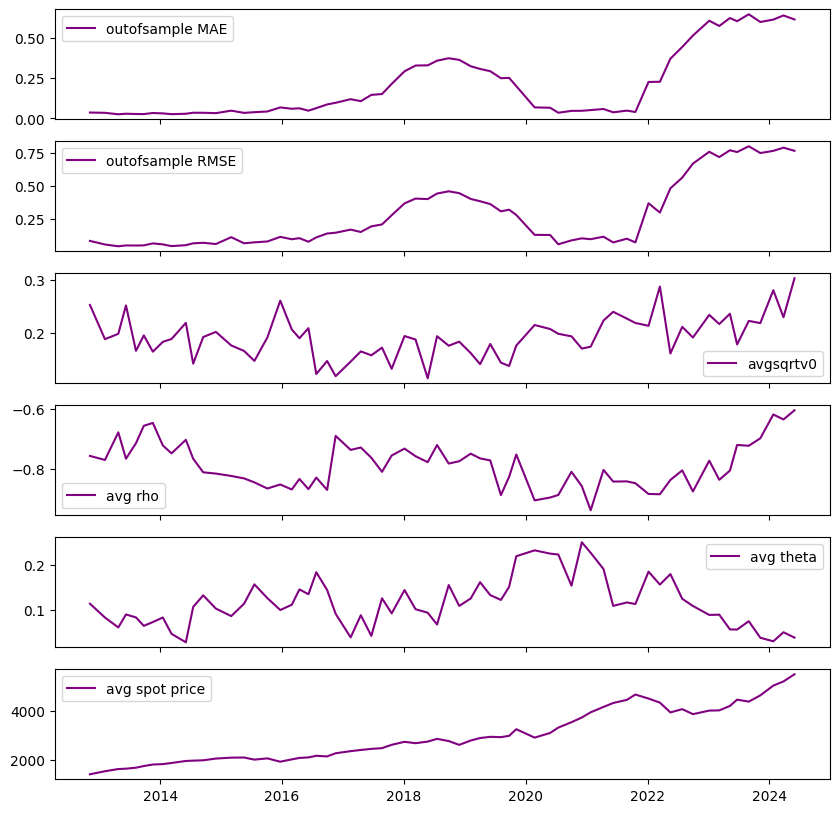

In [14]:
PlotCols(df,figsize=(10,10))

In [15]:
test_data = model['test_data'].copy()

test_data['sqrtv0'] = np.sqrt(test_data['v0'])
sqrtv0 = test_data['sqrtv0']
quants = sqrtv0.describe()[3:]
quants

min    0.010116
25%    0.110255
50%    0.150609
75%    0.247780
max    0.780206
Name: sqrtv0, dtype: float64

In [16]:
test_data[['v0','sqrtv0','relative_spot',]].describe()

,v0,sqrtv0,relative_spot
count,3.584880e+06,3.584880e+06,3.584880e+06
mean,5.654756e-02,1.942774e-01,1.128780e+00
std,8.399196e-02,1.371272e-01,4.190065e-01
min,1.023359e-04,1.011612e-02,6.666667e-01
25%,1.215609e-02,1.102547e-01,8.000000e-01
50%,2.268296e-02,1.506086e-01,1.000000e+00
75%,6.139471e-02,2.477796e-01,1.333333e+00
max,6.087220e-01,7.802064e-01,2.000000e+00


In [ ]:
print(test_data.dtypes)

In [ ]:
test_data['observed_price'] = test_data['relative_observed']*test_data['strike_price']
test_data['relative_error'] = test_data['observed_price']/test_data[pricename]-1

# visual inspection

In [ ]:
sns.kdeplot(data=test_data, x='observed_price', label='Estimated', color='purple')
sns.histplot(data=test_data, x=pricename, label='Target', color='green', stat='density', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
train_zoom = test_data[
    (test_data['relative_observed']>0.05)
    &(test_data['relative_observed']<0.5)
]
sns.kdeplot(data=train_zoom, x='observed_price', label='Estimated', color='purple')
sns.histplot(data=train_zoom, x=pricename, label='Target', color='green', stat='density', alpha=0.5)
plt.legend()
plt.show()

# feature importance

In [ ]:
from sklearn.inspection import permutation_importance
train = model['train_data'].copy()

r = permutation_importance(initial, train[model['feature_set']], train[model['target_name']],
                           n_repeats=30,
                           random_state=1312,
                           scoring='neg_mean_squared_error'
                          )
importances = pd.DataFrame(data=r['importances'],index=model['feature_set']).T
importances_mean = pd.Series(r['importances_mean'],index=model['feature_set'])
importances_std = pd.Series(r['importances_std'],index=model['feature_set'])
importances

In [ ]:
security_tag = pricename[:pricename.find('_')].title()+' Options'

In [ ]:
import plotly.express as px
fig = px.box(
    importances[ model['feature_set']
        # 'kappa','theta','rho','eta','v0',
        # # 'relative_spot'
    ],
    height=1000,
    width=1200,
    facet_col_spacing=0,
    facet_row_spacing=0,
    notched=True, 
    title=f'Feature Importance for {security_tag}'
)
fig.update_xaxes(title='Feature')
fig.update_yaxes(title='')

# partial dependence

In [ ]:
import matplotlib.pyplot as plt
from time import time
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

heston_and_price = ['kappa','relative_spot','theta','rho','eta','v0']
print("Computing partial dependence plots...")
features_info = {
    "features": heston_and_price,
    "kind": "average",
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    initial,
    model['train_X'],
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        f"Partial dependence of {pricename.replace('_',' option ')}s"
    ),
    fontsize=16,
)

In [ ]:
PDPfeatures = [f for f in model['numerical_features']]
features_info = {
    "features": PDPfeatures,
    "kind": "average",
    "categorical_features":model['categorical_features']
}
tic = time()
_, ax = plt.subplots(figsize=(9, 9), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    initial,
    model['train_X'],
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        f"Partial dependence of {pricename.replace('_',' option ')}s"
    ),
    fontsize=16,
)

In [ ]:
sns.pairplot(test_data[['kappa','theta','rho','eta','v0']])